In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.sql import functions as F

# Create a spark session
spark = (
    SparkSession.builder.appName("analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "6g")
    .getOrCreate()
)

In [2]:
postcode_ratio_sdf = spark.read.parquet("../data/curated/postcode_ratio_sdf.parquet/")
print(postcode_ratio_sdf.count())
postcode_ratio_sdf.limit(5)

5988


postcode,sa2_code,sa2_name,ratio
0800,701011002,Darwin City,1.0
0810,701021010,Alawa,0.0719971
0810,701021013,Brinkin - Nakara,0.0963918
0810,701021016,Coconut Grove,0.0964936
0810,701021018,Jingili,0.061562


## Join postcode data with population data

In [3]:
pop_sdf = spark.read.parquet("../data/curated/pop_sdf.parquet/")
print(pop_sdf.count())
populationdf = pop_sdf.withColumnRenamed("SA2 code","sa2_code")
populationdf.limit(5)

2450


State/Terr,sa2_code,SA2 name,Total,Under 10,Adolescent,Young adult,Middle age,Old
New South Wales,115011556,Castle Hill - South,10436,1256,1454,1704,3718,2304
New South Wales,115011557,Castle Hill - West,5198,568,849,810,1928,1043
New South Wales,115011558,Cherrybrook,19135,1982,3084,2522,6760,4787
New South Wales,115011621,Kellyville - East,17748,2300,3032,2748,6701,2967
New South Wales,115011622,Kellyville - West,11417,1702,1453,2162,4067,2033


In [4]:
merged_sdf1 = populationdf.join(postcode_ratio_sdf, on="sa2_code", how="inner")

In [5]:
merged_sdf1.groupBy("sa2_code").count().count()

1900

Lost 550 records for which there were no sa2 codes

In [6]:
merged_sdf1.orderBy("postcode").limit(5)

sa2_code,State/Terr,SA2 name,Total,Under 10,Adolescent,Young adult,Middle age,Old,postcode,sa2_name,ratio
701011002,Northern Territory,Darwin City,7679,474,325,3322,2652,906,0800,Darwin City,1.0
701021018,Northern Territory,Jingili,1922,301,274,335,702,310,0810,Jingili,0.061562
701021025,Northern Territory,Nightcliff,4112,490,393,1204,1371,654,0810,Nightcliff,0.1239038
701021021,Northern Territory,Lyons (NT),6356,1310,902,1610,2185,349,0810,Lyons (NT),0.0702012
701021023,Northern Territory,Millner,2726,341,259,709,947,470,0810,Millner,0.0834829


Get a single population value for each postcode and field by calculating the weighted average using ratio

In [66]:
postcode_pop_sdf = merged_sdf1.groupBy("postcode") \
    .agg(
        F.round((F.sum(merged_sdf1.Total * merged_sdf1.ratio) / F.sum(merged_sdf1.ratio)), 2).alias("total_pop"),
        F.round((F.sum(merged_sdf1["Under 10"] * merged_sdf1.ratio) / F.sum(merged_sdf1.ratio)), 2).alias("under10_pop"),
        F.round((F.sum(merged_sdf1.Adolescent * merged_sdf1.ratio) / F.sum(merged_sdf1.ratio)), 2).alias("adolsc_pop"),
        F.round((F.sum(merged_sdf1["Young adult"] * merged_sdf1.ratio) / F.sum(merged_sdf1.ratio)), 2).alias("yng_adult_pop"),
        F.round((F.sum(merged_sdf1["Middle age"] * merged_sdf1.ratio) / F.sum(merged_sdf1.ratio)), 2).alias("mid_age_pop"),
        F.round((F.sum(merged_sdf1.Old * merged_sdf1.ratio) / F.sum(merged_sdf1.ratio)), 2).alias("old_pop")
    )
    
postcode_pop_sdf.orderBy("postcode").show()

+--------+---------+-----------+----------+-------------+-----------+-------+
|postcode|total_pop|under10_pop|adolsc_pop|yng_adult_pop|mid_age_pop|old_pop|
+--------+---------+-----------+----------+-------------+-----------+-------+
|    0800|   7679.0|      474.0|     325.0|       3322.0|     2652.0|  906.0|
|    0810|  3121.46|     419.06|    345.41|        819.6|    1043.92| 493.46|
|    0812|  4308.01|     621.82|    571.11|        844.5|    1475.39|  795.2|
|    0820|  3420.98|     358.95|    316.31|      1032.65|     1172.7| 540.38|
|    0822|  5099.87|      767.1|    868.74|      1295.53|    1631.41| 537.08|
|    0828|   1814.0|      224.0|     302.0|        433.0|      624.0|  231.0|
|    0829|  5673.15|     467.32|    532.63|      1749.75|    2035.05|  888.4|
|    0830|  3671.22|     610.12|    484.28|       848.18|    1275.16| 453.48|
|    0832|  5142.17|     918.67|    704.86|      1351.13|    1692.51|  475.0|
|    0835|  4819.67|     408.13|    493.88|      1347.38|    172

Visualize the population variation for each SA2 code within each postcode

In [21]:
pop_diffs = merged_sdf1.groupBy("postcode").agg(
    (F.max(merged_sdf1.Total) - F.min(merged_sdf1.Total)).alias("Total"),
    (F.max(merged_sdf1["Under 10"]) - F.min(merged_sdf1["Under 10"])).alias("Under 10"),
    (F.max(merged_sdf1.Adolescent) - F.min(merged_sdf1.Adolescent)).alias("Adolescent"),
    (F.max(merged_sdf1["Young adult"]) - F.min(merged_sdf1["Young adult"])).alias("Young adult"),
    (F.max(merged_sdf1["Middle age"]) - F.min(merged_sdf1["Middle age"])).alias("Middle age"),
    (F.max(merged_sdf1.Old) - F.min(merged_sdf1.Old)).alias("Old")
)

In [42]:
pop_diffs.limit(5)

postcode,Total,Under 10,Adolescent,Young adult,Middle age,Old
2069,0,0,0,0,0,0
2136,2946,413,298,1090,842,303
2162,1631,806,162,848,37,222
2294,9168,883,696,2927,3008,1654
2110,5619,740,153,1960,2277,489


/tmp/ipykernel_260/1227780644.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['Total', 'Under 10',


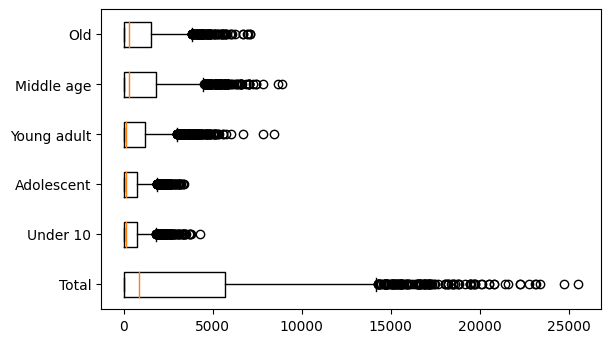

In [52]:
fig1 = plt.figure(figsize = (5, 3))
ax1 = fig1.add_axes([0, 0, 1, 1])
ax1.set_yticklabels(['Total', 'Under 10',
                    'Adolescent', 'Young adult',
                    'Middle age', 'Old'])
bp = ax1.boxplot(pop_diffs.drop("postcode").toPandas(), vert=0)

plt.show()

## Join postcode data with income data

In [44]:
incomedf = spark.read.parquet("../data/curated/incomedf.parquet/")
print(incomedf.count())
incomedf.limit(5)

2239


sa2_code,num_earners,median_age,median_income,mean_income
213011340,11238,46,51181,61177
213021341,7942,43,57585,69301
213021344,11216,41,66161,80219
213021345,3015,41,52078,60249
213021346,9996,47,63892,90668


In [45]:
merged_sdf2 = incomedf.join(postcode_ratio_sdf, on="sa2_code", how="inner")

In [46]:
merged_sdf2.groupBy("sa2_code").count().count()

2010

Lost 229 records for which there were no sa2 codes

In [47]:
merged_sdf2.orderBy("postcode").limit(5)

sa2_code,num_earners,median_age,median_income,mean_income,postcode,sa2_name,ratio
701011002,5909,33,60937,87791,0800,Darwin City,1.0
701021010,1387,40,54188,61411,0810,Alawa,0.0719971
701021013,2395,39,52335,67299,0810,Brinkin - Nakara,0.0963918
701021016,1878,36,55124,65051,0810,Coconut Grove,0.0964936
701021018,1166,43,58753,69389,0810,Jingili,0.061562


Again, use the weighted average approach for the income data

In [67]:
postcode_income_sdf = merged_sdf2.groupBy("postcode") \
    .agg(
        F.round((F.sum(merged_sdf2.num_earners * merged_sdf2.ratio) / F.sum(merged_sdf2.ratio)), 2).alias("num_earners"),
        F.round((F.sum(merged_sdf2.median_age * merged_sdf2.ratio) / F.sum(merged_sdf2.ratio)), 2).alias("median_age"),
        F.round((F.sum(merged_sdf2.median_income * merged_sdf2.ratio) / F.sum(merged_sdf2.ratio)), 2).alias("median_income"),
        F.round((F.sum(merged_sdf2.mean_income * merged_sdf2.ratio) / F.sum(merged_sdf2.ratio)), 2).alias("mean_income")
    )
    
postcode_income_sdf.orderBy("postcode").show()

+--------+-----------+----------+-------------+-----------+
|postcode|num_earners|median_age|median_income|mean_income|
+--------+-----------+----------+-------------+-----------+
|    0800|     5909.0|      33.0|      60937.0|    87791.0|
|    0810|    1904.63|      39.1|      59653.0|   70087.24|
|    0812|    2524.63|     41.61|     61325.63|   68985.95|
|    0820|    2420.53|      39.1|     63857.71|   82498.57|
|    0822|     1029.6|     39.79|     38878.56|   49409.36|
|    0828|      686.0|      43.0|      58107.0|    70769.0|
|    0829|    2606.59|     41.67|     66021.74|   75514.21|
|    0830|    2132.04|     38.08|     63842.77|   71009.53|
|    0832|    3073.36|     36.21|     69019.03|   77275.87|
|    0835|    2407.18|     42.77|     64587.37|    73991.2|
|    0836|     5418.0|      43.0|      65045.0|    75486.0|
|    0837|     2474.0|      43.0|      61215.0|    69902.0|
|    0838|     2474.0|      43.0|      61215.0|    69902.0|
|    0840|     2189.0|      46.0|      5

Visualize the income variation for each SA2 code within each postcode

In [48]:
income_diffs = merged_sdf2.groupBy("postcode").agg(
    (F.max(merged_sdf2.num_earners) - F.min(merged_sdf2.num_earners)).alias("num_earners"),
    (F.max(merged_sdf2.median_age) - F.min(merged_sdf2.median_age)).alias("median_age"),
    (F.max(merged_sdf2.median_income) - F.min(merged_sdf2.median_income)).alias("median_income"),
    (F.max(merged_sdf2.mean_income) - F.min(merged_sdf2.mean_income)).alias("mean_income")
)

In [56]:
income_diffs.limit(5)

postcode,num_earners,median_age,median_income,mean_income
2069,3202,8,17642,54160
2088,0,0,0,0
2136,242,3,5460,9609
2162,63,4,3418,2543
2294,5051,8,16543,13130


/tmp/ipykernel_260/3120451410.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['num_earners', 'median_age',


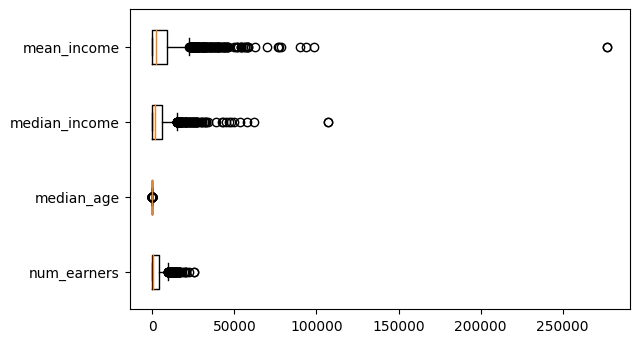

In [54]:
fig2 = plt.figure(figsize = (5, 3))
ax2 = fig2.add_axes([0, 0, 1, 1])
ax2.set_yticklabels(['num_earners', 'median_age',
                    'median_income', 'mean_income'])
bp = ax2.boxplot(income_diffs.drop("postcode").toPandas(), vert=0)

plt.show()

Combine all external data in a single spark dataframe

In [13]:
print(postcode_pop_sdf.count(), postcode_income_sdf.count())

2422 2493


In [14]:
external_data_sdf = postcode_pop_sdf.join(postcode_income_sdf, on="postcode", how="full")
print(external_data_sdf.count())
external_data_sdf.limit(5)

2494


postcode,wavg_pop_total,wavg_pop_under10,wavg_pop_adolsc,wavg_pop_yng_adult,wavg_pop_mid_age,wavg_pop_old,wavg_num_earners,wavg_median_age,wavg_median_income,wavg_mean_income
0800,7679.0,474.0,325.0,3322.0,2652.0,906.0,5909.0,33.0,60937.0,87791.0
0810,3121.46,419.06,345.41,819.6,1043.92,493.46,1904.63,39.1,59653.0,70087.24
0812,4308.01,621.82,571.11,844.5,1475.39,795.2,2524.63,41.61,61325.63,68985.95
0820,3420.98,358.95,316.31,1032.65,1172.7,540.38,2420.53,39.1,63857.71,82498.57
0822,5099.87,767.1,868.74,1295.53,1631.41,537.08,1029.6,39.79,38878.56,49409.36


## Join External data with existing data

In [15]:
sdf = spark.read.parquet("../data/curated/mergedf.parquet/")
print(sdf.count())
sdf.limit(5)

13613661


merchant_abn,consumer_id,user_id,dollar_value,order_id,order_datetime,customer_name,address,state,postcode,gender,company_name,tags,take_rate,revenue_band
69666829657,226,5162,79.65159982605903,8765ef9f-dba6-407...,2021-08-20,Courtney Torres,6945 Higgins Brooks,SA,5581,Female,Sem Ut Institute,bicycle shops - s...,2.86,c
49891706470,226,5162,3.887089224741017,9ba8ebb2-6593-49f...,2022-07-13,Courtney Torres,6945 Higgins Brooks,SA,5581,Female,Non Vestibulum In...,tent and awning s...,5.80,a
70610974780,226,5162,52.820359204536665,bdf345c8-4c5d-48e...,2021-08-20,Courtney Torres,6945 Higgins Brooks,SA,5581,Female,Elit Aliquam PC,tent and awning s...,6.93,a
85276983280,226,5162,250.33729038347653,dcad871d-1b75-4a8...,2022-05-06,Courtney Torres,6945 Higgins Brooks,SA,5581,Female,Lacus Varius Corp.,florists supplies...,3.32,b
15582655078,226,5162,75.31904078962366,47ddf8e0-5f72-408...,2021-08-21,Courtney Torres,6945 Higgins Brooks,SA,5581,Female,Eu Odio Phasellus...,"gift, card, novel...",6.77,a


In [16]:
finaldf = sdf.join(external_data_sdf, on="postcode", how="inner")
print(finaldf.count())
finaldf.limit(5)

10634088


postcode,merchant_abn,consumer_id,user_id,dollar_value,order_id,order_datetime,customer_name,address,state,gender,company_name,tags,take_rate,revenue_band,wavg_pop_total,wavg_pop_under10,wavg_pop_adolsc,wavg_pop_yng_adult,wavg_pop_mid_age,wavg_pop_old,wavg_num_earners,wavg_median_age,wavg_median_income,wavg_mean_income
2088,92343252737,94481,7298,34.91159012072029,93e9ca4b-f453-4ff...,2022-04-22,Bryan Ware,261 Cowan Plaza S...,NSW,Male,Ornare Libero At ...,digital goods: bo...,6.77,a,null,null,null,null,null,null,20612.0,47.0,75307.0,166807.0
2088,42543374304,94481,7298,354.36723243531003,030ff583-1863-4c7...,2021-08-20,Bryan Ware,261 Cowan Plaza S...,NSW,Male,Morbi Metus Vivam...,computer programm...,6.17,a,null,null,null,null,null,null,20612.0,47.0,75307.0,166807.0
2088,30122382323,94481,7298,60.71913021777211,b1270100-b1af-4b4...,2022-06-02,Bryan Ware,261 Cowan Plaza S...,NSW,Male,Ipsum Company,"watch, clock, and...",3.36,b,null,null,null,null,null,null,20612.0,47.0,75307.0,166807.0
2088,35367341543,94481,7298,65.98726779920248,19ab4547-0e04-496...,2021-08-21,Bryan Ware,261 Cowan Plaza S...,NSW,Male,Rhoncus Id Company,"gift, card, novel...",6.40,a,null,null,null,null,null,null,20612.0,47.0,75307.0,166807.0
2088,82368304209,94481,7298,2247.6294931000416,91f42676-6c76-4ed...,2022-05-25,Bryan Ware,261 Cowan Plaza S...,NSW,Male,Nec Incorporated,telecom,5.55,a,null,null,null,null,null,null,20612.0,47.0,75307.0,166807.0


Null values occur because for some postcodes, population/income data did not exist.

In [17]:
finaldf = finaldf.dropna(how="any")
finaldf.count()

22/09/21 05:32:03 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


10320037

Removing records containing null values resulted in the loss of 314,051 records.